In [1]:
import numpy as np
import scipy.linalg as scp
import matplotlib.pyplot as plt
import torch
import time

In [2]:
from src.dynamics import RobotWorld
from src.controllers.lqr import Lqr
from src.config import Config

# LQR

In [3]:
G = - torch.eye(4)
R = - torch.eye(2) * 0.1

T = 1_000

In [4]:
env = RobotWorld()
controller = Lqr(env.A, env.B, G, R)

states = torch.zeros([T, 4])
actions = torch.zeros([T, 2])

s = env.reset()
for i in range(0, T):
    u = controller.pi(s)
    sp = env.step(u)

    states[i] = s
    actions[i] = u

    s = sp[::]

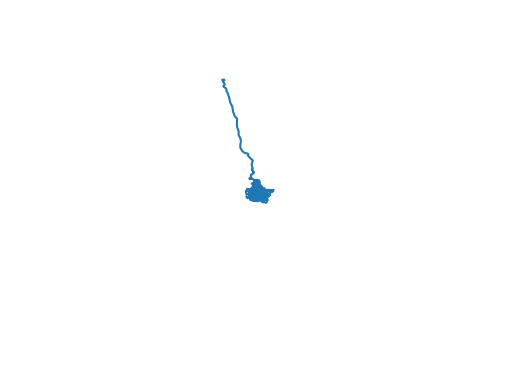

In [5]:
plt.plot(states[:, 0], states[:, 1])
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.axis('off')
plt.show()

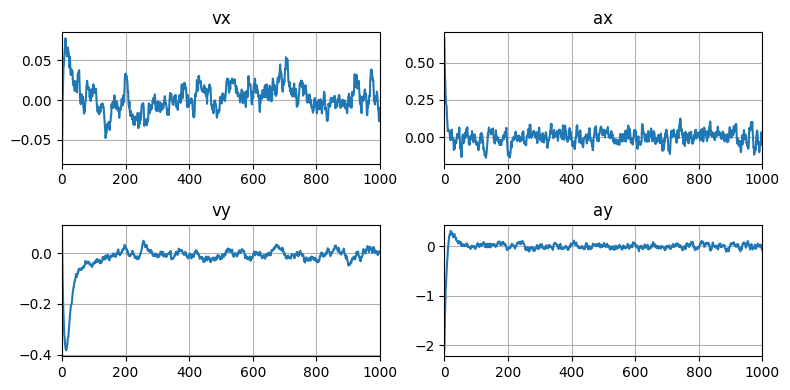

In [6]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=[8, 4])

axes[0, 0].plot(states[:, 2])
axes[0, 0].grid()
axes[0, 0].set_title("vx")
axes[0, 0].set_xlim(0, T)

axes[1, 0].plot(states[:, 3])
axes[1, 0].grid()
axes[1, 0].set_title("vy")
axes[1, 0].set_xlim(0, T)

axes[0, 1].plot(actions[:, 0])
axes[0, 1].grid()
axes[0, 1].set_title("ax")
axes[0, 1].set_xlim(0, T)

axes[1, 1].plot(actions[:, 1])
axes[1, 1].grid()
axes[1, 1].set_title("ay")
axes[1, 1].set_xlim(0, T)

plt.tight_layout()
plt.show()

# Discounted LQR

In [7]:
G = - torch.eye(4)
R = - torch.eye(2) * 0.1

gamma = torch.tensor(0.99)

T = 1_000

In [8]:
env = RobotWorld()
controller = Lqr(
    A=torch.sqrt(gamma) * env.A,
    B=torch.sqrt(gamma) * env.B,
    G=G,
    R=R
)

states = torch.zeros([T, 4])
actions = torch.zeros([T, 2])

s = env.reset()
for i in range(0, T):
    u = controller.pi(s)
    sp = env.step(u)

    states[i] = s
    actions[i] = u

    s = sp[::]

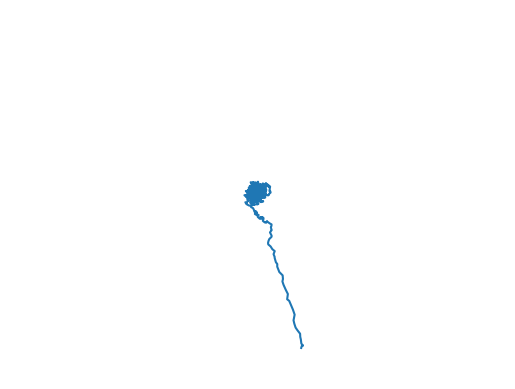

In [9]:
plt.plot(states[:, 0], states[:, 1])
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.axis('off')
plt.show()

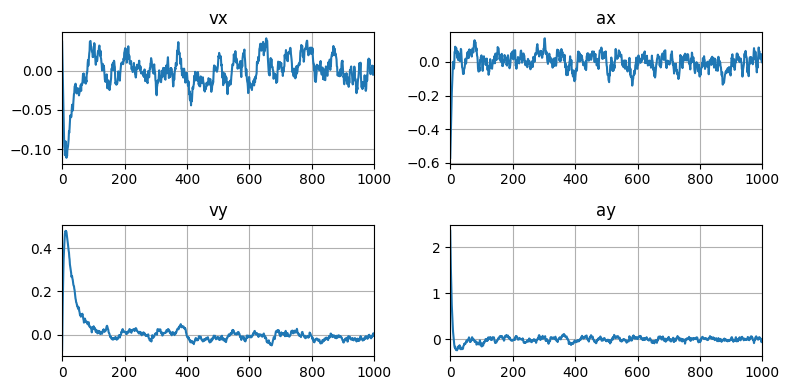

In [10]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=[8, 4])

axes[0, 0].plot(states[:, 2])
axes[0, 0].grid()
axes[0, 0].set_title("vx")
axes[0, 0].set_xlim(0, T)

axes[1, 0].plot(states[:, 3])
axes[1, 0].grid()
axes[1, 0].set_title("vy")
axes[1, 0].set_xlim(0, T)

axes[0, 1].plot(actions[:, 0])
axes[0, 1].grid()
axes[0, 1].set_title("ax")
axes[0, 1].set_xlim(0, T)

axes[1, 1].plot(actions[:, 1])
axes[1, 1].grid()
axes[1, 1].set_title("ay")
axes[1, 1].set_xlim(0, T)

plt.tight_layout()
plt.show()

# Exact DPGPD - Unconstrained

In [290]:
from scipy.linalg import solve_discrete_lyapunov

In [291]:
def get_p(A, B, G, R, K, gamma):
    M = G + K.T @ R @ K
    L = torch.sqrt(gamma) * (A + B @ K)
    P = solve_discrete_lyapunov(L, M)
    return P

def get_k(A, B, R, K, P, I_eta, gamma):
    H_odiag = gamma * B.T @ P @ A
    H_diag = R + gamma * B.T @ P @ B
    return - torch.inverse(2 * H_diag + 2 * R - I_eta) @ (2 * H_odiag + I_eta @ K)

def get_v(env, P):
    vs = 0
    for _ in range(1_000):
        s = env.reset()
        vs += s @ P @ s
    return (vs / 1_000).detach().item()


In [300]:
ds = 4
da = 2

eta = torch.tensor(0.01).double()
tau = torch.tensor(0.001).double()
gamma = torch.tensor(0.9).double()

G1 = - torch.eye(ds).double()
R1 = - torch.eye(da).double() * (tau / 2)
G2 = - torch.tensor([
    [.001, 0, 0, 0],
    [0, .001, 0, 0],
    [0, 0, .001, 0],
    [0, 0, 0, .001]
])
R2 = - torch.tensor([
    [1., 0],
    [0, 1.],
]).double()

I_eta = torch.eye(da).double() * (1 / eta)

In [301]:
K = torch.randn(da, ds).double() * 0.1
loss_primal, loss_dual = [], []
for i in range(1_000):
    P_primal = get_p(env.A, env.B, G1, R1, K, gamma)
    P_dual = get_p(env.A, env.B, G2, R2, K, gamma)

    loss_primal.append(get_v(env, P_primal))
    loss_dual.append(get_v(env, P_dual))

    K = get_k(env.A, env.B, R1, K, P_primal, I_eta, gamma)

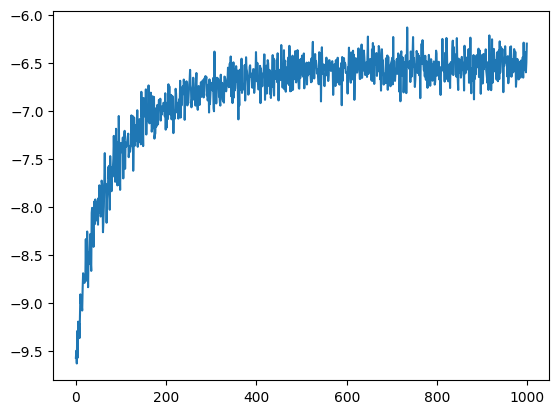

In [302]:
plt.plot(loss_primal)
plt.show()

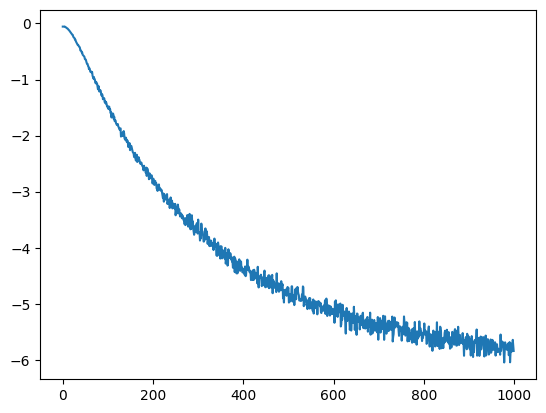

In [303]:
plt.plot(loss_dual)
plt.show()

In [304]:
env = RobotWorld()

states = torch.zeros([T, 4])
actions = torch.zeros([T, 2])

s = env.reset()
for i in range(0, T):
    u = s @ K.T
    sp = env.step(u)

    states[i] = s
    actions[i] = u

    s = sp[::]

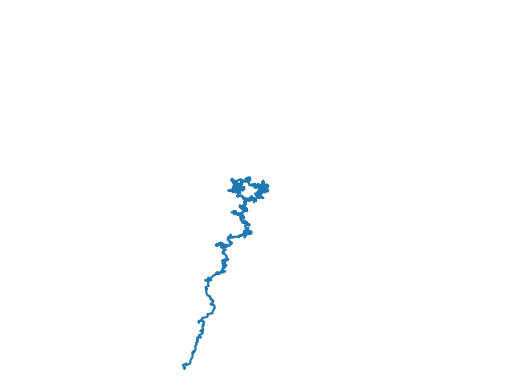

In [305]:
plt.scatter([0], [0], marker='*')
plt.plot(states[:, 0], states[:, 1])
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.axis('off')
plt.show()

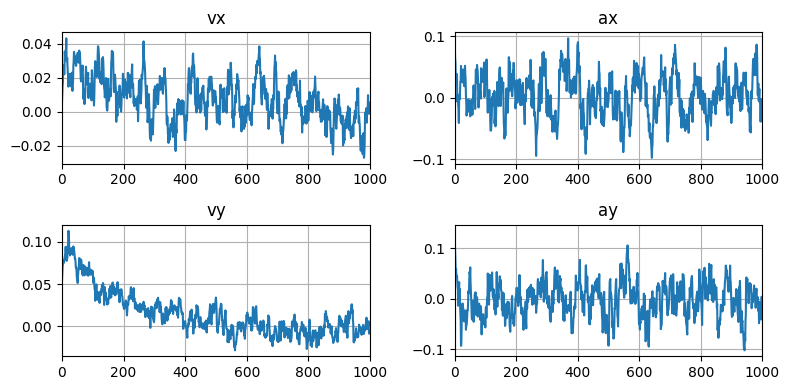

In [306]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=[8, 4])

axes[0, 0].plot(states[:, 2])
axes[0, 0].grid()
axes[0, 0].set_title("vx")
axes[0, 0].set_xlim(0, T)

axes[1, 0].plot(states[:, 3])
axes[1, 0].grid()
axes[1, 0].set_title("vy")
axes[1, 0].set_xlim(0, T)

axes[0, 1].plot(actions[:, 0])
axes[0, 1].grid()
axes[0, 1].set_title("ax")
axes[0, 1].set_xlim(0, T)

axes[1, 1].plot(actions[:, 1])
axes[1, 1].grid()
axes[1, 1].set_title("ay")
axes[1, 1].set_xlim(0, T)

plt.tight_layout()
plt.show()

# Exact DPGPD - Constrained

In [20]:
def update_lq(G1, G2, R1, R2, lmbda):
    return G1 + lmbda * G2, R1 + lmbda * R2

def get_p(A, B, G, R, K, gamma):
    M = G + K.T @ R @ K
    L = torch.sqrt(gamma) * (A + B @ K)
    P = solve_discrete_lyapunov(L, M)
    return P

def primal_update(A, B, R, K, P, I_eta, gamma):
    H_odiag = gamma * B.T @ P @ A
    H_diag = R + gamma * B.T @ P @ B
    return - torch.inverse(2 * H_diag + 2 * R - I_eta) @ (2 * H_odiag + I_eta @ K)

def get_v(env, P):
    vs = 0
    for _ in range(1_000):
        s = env.reset()
        vs += s @ P @ s
    return (vs / 1_000).detach().item()

def dual_update(env, P, b, lmbda, eta, tau):
    v = get_v(env, P)
    return torch.clamp(lmbda - eta * (v - b + tau * lmbda), min=0)

In [21]:
ds = 4
da = 2

eta = torch.tensor(0.01).double()
tau = torch.tensor(0.001).double()
gamma = torch.tensor(0.9).double()
b = torch.tensor(-4).double()

G1 = - torch.eye(ds).double()
R1 = - torch.eye(da).double() * (tau / 2)
G2 = - torch.tensor([
    [.001, 0, 0, 0],
    [0, .001, 0, 0],
    [0, 0, .001, 0],
    [0, 0, 0, .001]
])
R2 = - torch.tensor([
    [1., 0],
    [0, 1.],
]).double()

I_eta = torch.eye(da).double() * (1 / eta)

In [22]:
K = torch.randn(da, ds).double() * 0.1
lmbda = 0.1
loss_primal, loss_dual = [], []
for _ in range(1_000):
    Gl, Rl = update_lq(G1, G2, R1, R2, lmbda)

    P_primal = get_p(env.A, env.B, Gl, Rl, K, gamma)
    P_primal_unconstrained = get_p(env.A, env.B, G1, R1, K, gamma)
    P_dual = get_p(env.A, env.B, G2, R2, K, gamma)

    loss_primal.append(get_v(env, P_primal_unconstrained))
    loss_dual.append(get_v(env, P_dual))

    # Primal update
    K = primal_update(env.A, env.B, Rl, K, P_primal, I_eta, gamma)

    # Dual update
    lmbda = dual_update(env, P_dual, b, lmbda, eta, tau)

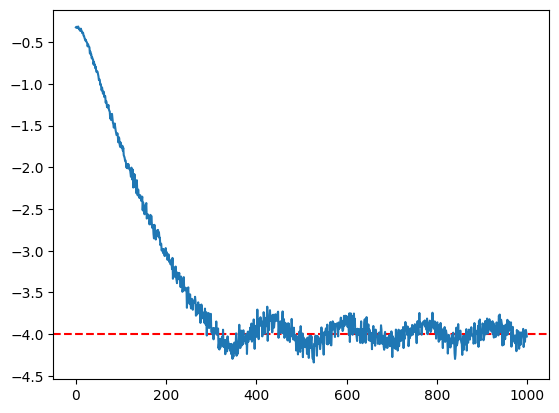

In [23]:
plt.axhline(y=b, color='r', linestyle='--')
plt.plot(loss_dual)
plt.show()

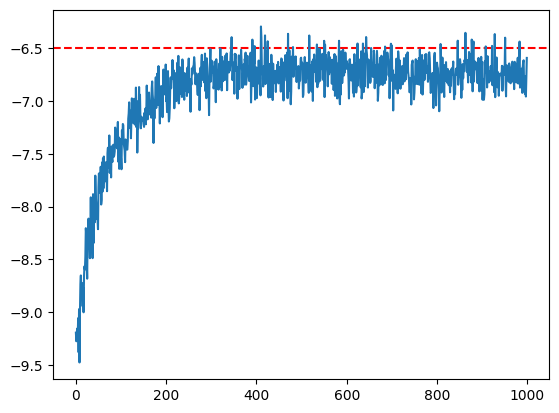

In [24]:
plt.axhline(y=-6.5, color='r', linestyle='--')
plt.plot(loss_primal)
plt.show()

In [25]:
env = RobotWorld()

states = torch.zeros([T, 4])
actions = torch.zeros([T, 2])

s = env.reset()
for i in range(0, T):
    u = s @ K.T
    sp = env.step(u)

    states[i] = s
    actions[i] = u

    s = sp[::]

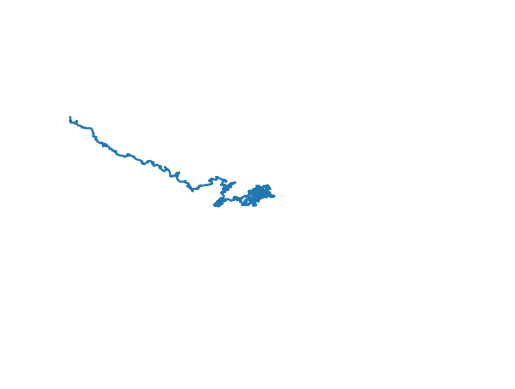

In [26]:
plt.scatter([0], [0], marker='*')
plt.plot(states[:, 0], states[:, 1])
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.axis('off')
plt.show()

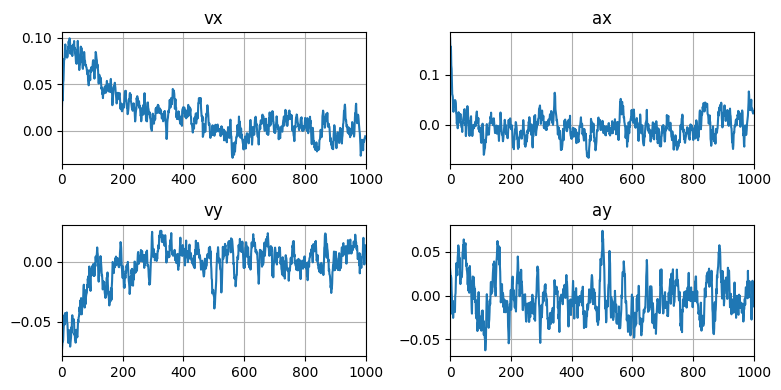

In [27]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=[8, 4])

axes[0, 0].plot(states[:, 2])
axes[0, 0].grid()
axes[0, 0].set_title("vx")
axes[0, 0].set_xlim(0, T)

axes[1, 0].plot(states[:, 3])
axes[1, 0].grid()
axes[1, 0].set_title("vy")
axes[1, 0].set_xlim(0, T)

axes[0, 1].plot(actions[:, 0])
axes[0, 1].grid()
axes[0, 1].set_title("ax")
axes[0, 1].set_xlim(0, T)

axes[1, 1].plot(actions[:, 1])
axes[1, 1].grid()
axes[1, 1].set_title("ay")
axes[1, 1].set_xlim(0, T)

plt.tight_layout()
plt.show()

In [34]:
loss_primal, loss_dual = [], []
P_primal = get_p(env.A, env.B, G1, R1, K, gamma)
P_dual = get_p(env.A, env.B, G2, R2, K, gamma)
for _ in range(1_000):
    loss_primal.append(get_v(env, P_primal))
    loss_dual.append(get_v(env, P_dual))

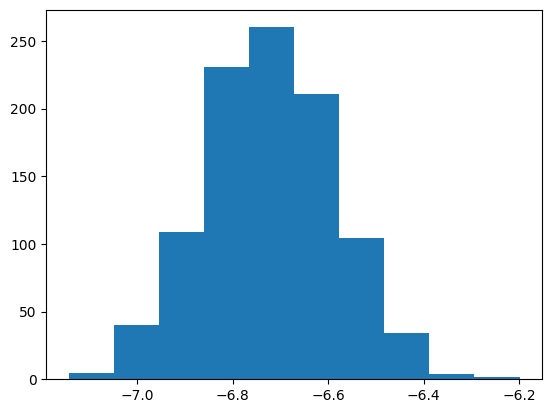

In [35]:
plt.hist(loss_primal)
plt.show()

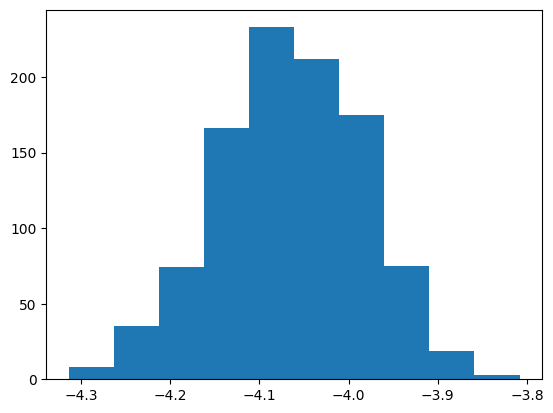

In [36]:
plt.hist(loss_dual)
plt.show()

# Unconstrained D-PG-PD / Exact Q

In [308]:
def get_estimator_weight(ds, da, theta, tau, eta, alpha):
    W_1 = np.zeros((da, ds))
    for i in range(da):
        for j in range(ds):
            s_idx, a_idx = torch.zeros(ds), torch.zeros(da)
            s_idx[j] = -1
            a_idx[i] = 1
            s_a_idx = torch.concat([s_idx, a_idx])
            mask = - torch.cartesian_prod(s_a_idx, s_a_idx).prod(dim=1).clip(-1, 0) 
            w = (theta * mask).sum()
            W_1[i, j] = w

    W_2 = torch.zeros((da, da))
    for i in range(da):
        for j in range(da):
            s_idx, a_idx = torch.zeros(ds), torch.zeros(da)
            a_idx[i] = 1
            a_idx[j] = -1
            s_a_idx = torch.concat([s_idx, a_idx])

            if i == j:
                mask = torch.cartesian_prod(s_a_idx, s_a_idx).prod(dim=1)
                w = (theta * mask).sum()
                W_2[i, j] = 2 * w * alpha
            else:
                mask = - torch.cartesian_prod(s_a_idx, s_a_idx).prod(dim=1).clip(-1, 0) 
                w = (theta * mask).sum()
                W_2[i, j] = w
    K = - torch.inverse(W_2 - (tau + 1 / eta) * torch.eye(da)) @ W_1
    return K.double()


In [311]:
def get_v(s, P):
    return s @ P @ s

def estimate_primal_loss(env, P):
    vs = 0
    for _ in range(1_000):
        s = env.reset()
        vs += s @ P @ s
    return (vs / 1_000).detach().item()

def get_Q(s, a, H):
    return torch.cat((s, a), dim=0) @ H @ torch.cat((s, a), dim=0) 

def get_p(A, B, G, R, K, gamma):
    M = G + K.T @ R @ K
    L = torch.sqrt(gamma) * (A + B @ K)
    P = solve_discrete_lyapunov(L, M)
    return P

def get_h(A, B, P, G, R):
    H_11 = G + gamma * A.T @ P @ A
    H_12 = gamma * A.T @ P @ B
    H_21 = gamma * B.T @ P @ A
    H_22 = R + gamma * B.T @ P @ B

    top = torch.cat((H_11, H_12), dim=1)
    bot = torch.cat((H_21, H_22), dim=1)

    H = torch.cat((top, bot), dim=0)
    return H

In [312]:
def get_initial_point():
    rng = np.random.default_rng()

    s = torch.tensor([
        rng.uniform(-5, 5),
        rng.uniform(-5, 5),
        rng.uniform(-5, 5),
        rng.uniform(-5, 5),
    ]).double()

    a = torch.tensor([
        rng.uniform(-5, 5),
        rng.uniform(-5, 5),
    ]).double()

    return s, a

In [313]:
def policy_evaluation(env, K, gamma, eta, alpha, N, theta, G, R):
    X, y = torch.zeros((N, 36)), torch.zeros(N)
    P = get_p(env.A, env.B, G, R, K, gamma)
    H = get_h(env.A, env.B, P, G, R)
    for n in range(N):
        s, a = get_initial_point()
        s_a = torch.concat([s, a])
        b = torch.flatten(torch.ger(s_a, s_a) + torch.diag((alpha - 1) * s_a**2))

        a_pi = s @ K.T
        q = get_Q(s, a, H)
        l = q + (1 / eta) * a_pi @ a

        X[n] = b
        y[n] = l

    theta = torch.linalg.lstsq(X, y, driver='gelsd').solution

    y_pred = torch.matmul(X, theta)
    mse = torch.sum((y_pred - y)**2) / N
    print(f"MSE: {mse} - MR: {(y_pred - y).mean()} - Means: {y_pred.mean()} / {y.mean()}")

    return theta

In [314]:
ds = 4
da = 2

eta = torch.tensor(0.1).double()
tau = torch.tensor(0.001).double()
gamma = torch.tensor(0.9).double()
b = torch.tensor(-4).double()

G = - torch.eye(ds).double()
R = - torch.eye(da).double() * (tau / 2)

N = 100_000
E = 10
alpha = 1.0

In [315]:
losses = []

env = RobotWorld()
theta = torch.rand((ds + da)**2) * 0.001
K = get_estimator_weight(ds, da, theta, tau, eta, alpha)

for e in range(E):
    theta = policy_evaluation(env, K, gamma, eta, alpha, N, theta, G, R)
    K = get_estimator_weight(ds, da, theta, tau, eta, alpha)

    P = get_p(env.A, env.B, G, R, K, gamma)
    loss = estimate_primal_loss(env, P)
    losses.append(loss)

    print(f"Episode {e}/{E} - Return {loss}")

MSE: 5.687635962203785e-07 - MR: -5.2290753956185654e-05 - Means: -404.5792541503906 / -404.5791931152344
Episode 0/10 - Return -9.354605129895576
MSE: 2.4806780629660352e-08 - MR: -4.432844070834108e-05 - Means: -378.1859130859375 / -378.18585205078125
Episode 1/10 - Return -8.727642869000597
MSE: 4.8205034630655064e-08 - MR: -0.00018147735681850463 - Means: -358.07000732421875 / -358.0697937011719
Episode 2/10 - Return -8.073589915011674
MSE: 2.0274333323300198e-08 - MR: 3.1025600037537515e-05 - Means: -344.4541931152344 / -344.4543151855469
Episode 3/10 - Return -7.978918506427668
MSE: 1.846438379971005e-08 - MR: 5.9704016166506335e-06 - Means: -333.5669250488281 / -333.5669250488281
Episode 4/10 - Return -7.862273406104581
MSE: 2.2857676640342106e-08 - MR: 8.401703962590545e-05 - Means: -322.9361877441406 / -322.9362487792969
Episode 5/10 - Return -7.810742200601501
MSE: 3.910607304646874e-08 - MR: 2.3698807126493193e-05 - Means: -315.88543701171875 / -315.88543701171875
Episode 6/

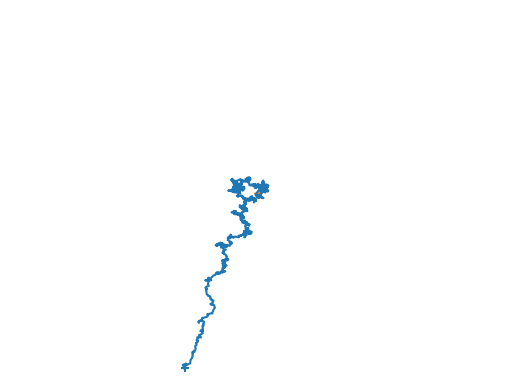

In [316]:
plt.scatter(states[0, 0], states[0, 1], marker='+')
plt.scatter([0], [0], marker='*')
plt.plot(states[:, 0], states[:, 1])
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.axis('off')
plt.show()

# Unconstrained D-PG-PD / Sample-based Q

In [ ]:
def get_estimator_weight(ds, da, theta, tau, eta, alpha):
    W_1 = np.zeros((da, ds))
    for i in range(da):
        for j in range(ds):
            s_idx, a_idx = torch.zeros(ds), torch.zeros(da)
            s_idx[j] = -1
            a_idx[i] = 1
            s_a_idx = torch.concat([s_idx, a_idx])
            mask = - torch.cartesian_prod(s_a_idx, s_a_idx).prod(dim=1).clip(-1, 0) 
            w = (theta * mask).sum()
            W_1[i, j] = w

    W_2 = torch.zeros((da, da))
    for i in range(da):
        for j in range(da):
            s_idx, a_idx = torch.zeros(ds), torch.zeros(da)
            a_idx[i] = 1
            a_idx[j] = -1
            s_a_idx = torch.concat([s_idx, a_idx])

            if i == j:
                mask = torch.cartesian_prod(s_a_idx, s_a_idx).prod(dim=1)
                w = (theta * mask).sum()
                W_2[i, j] = 2 * w * alpha
            else:
                mask = - torch.cartesian_prod(s_a_idx, s_a_idx).prod(dim=1).clip(-1, 0) 
                w = (theta * mask).sum()
                W_2[i, j] = w
    W = - torch.inverse(W_2 - (tau + 1 / eta) * torch.eye(da)) @ W_1
    return W.double()#, torch.tensor(W_1).double(), torch.tensor(W_2).double()


In [ ]:
def get_v(s, P):
    return s @ P @ s

def get_Q(s, a, H):
    return torch.cat((s, a), dim=0) @ H @ torch.cat((s, a), dim=0) 

def get_p(A, B, G, R, K, gamma):
    M = G + K.T @ R @ K
    L = torch.sqrt(gamma) * (A + B @ K)
    P = solve_discrete_lyapunov(L, M)
    return P

def get_h(A, B, P, G, R):
    H_11 = G + gamma * A.T @ P @ A
    H_12 = gamma * A.T @ P @ B
    H_21 = gamma * B.T @ P @ A
    H_22 = R + gamma * B.T @ P @ B

    top = torch.cat((H_11, H_12), dim=1)
    bot = torch.cat((H_21, H_22), dim=1)

    H = torch.cat((top, bot), dim=0)
    return H

In [ ]:
def pi(s, W):
    return s @ W.T

In [ ]:
def get_reward(Q, R, s, a):
    return s @ Q @ s + a @ R @ a

In [ ]:
def rollout(s, a, W, env, T, gamma, Q, R):
    env.s = s
    sp = env.step(a)
    r = get_reward(Q, R, s, a)
    s = sp

    q_hat = r
    for i in range(1, T):
        a = pi(s, W)
        sp = env.step(a)

        r = get_reward(Q, R, s, a)
        q_hat += (gamma**i) * r

        s = sp
    return q_hat

In [ ]:
def rollout_test(env, W, T, Q, R):
    s = env.reset()
    states = np.zeros((T, 4))
    actions = np.zeros((T, 2))
    ret = 0
    for t in range(T):
        a = pi(s, W)
        sp = env.step(a)
        r = get_reward(Q, R, s, a)

        states[t] = s.detach().numpy()
        actions[t] = a.detach().numpy()
        ret += r

        s = sp
    return states, actions, ret

In [ ]:
def get_initial_point(gamma, W, env):
    rng = np.random.default_rng()

    s = torch.tensor([
        rng.uniform(-5, 5),
        rng.uniform(-5, 5),
        rng.uniform(-5, 5),
        rng.uniform(-5, 5),
    ]).double()

    a = torch.tensor([
        rng.uniform(-5, 5),
        rng.uniform(-5, 5),
    ]).double()
    """
    env.s = s
    for _ in range(1_000):
        if torch.rand(1) > gamma:
            return s, a

        s = env.step(a)
        a = pi(s, W)
    """
    return s, a

In [ ]:
def policy_evaluation(env, W, T, gamma, eta, alpha, K, theta, G, R):
    X, y = torch.zeros((K, 36)), torch.zeros(K)
    P = get_p(env.A, env.B, G, R, W, gamma)
    H = get_h(env.A, env.B, P, G, R)
    for k in range(K):
        s, a = get_initial_point(gamma, W, env)
        s_a = torch.concat([s, a])
        # b = torch.cartesian_prod(s_a, s_a).prod(dim=1)
        b = torch.flatten(torch.ger(s_a, s_a) + torch.diag((alpha - 1) * s_a**2))

        a_pi = pi(s, W)
        q = get_Q(s, a, H)
        l = q + (1 / eta) * a_pi @ a
        #l = rollout(s, a, W, env, T, gamma, G, R) + (1 / eta) * a_pi @ a

        X[k] = b
        y[k] = l

    # theta = torch.clamp(torch.linalg.lstsq(X, y).solution, max=0)
    theta = torch.linalg.lstsq(X, y, driver='gelsd').solution
    #theta = torch.tensor(np.linalg.pinv(X.detach().numpy()) @ y.detach().numpy())

    y_pred = torch.matmul(X, theta)
    mse = torch.sum((y_pred - y)**2) / K
    print(f"MSE: {mse} - MR: {(y_pred - y).mean()} - Means: {y_pred.mean()} / {y.mean()}")

    return theta

In [ ]:
ds = 4
da = 2

eta = torch.tensor(0.1).double()
tau = torch.tensor(0.001).double()
gamma = torch.tensor(0.9).double()
b = torch.tensor(-4).double()

G = - torch.eye(ds).double()
R = - torch.eye(da).double() * (tau / 2)

T_train = 100
T_test = 1_000
K = 100_000
E = 10
alpha = 1.0

In [ ]:
theta = torch.rand((ds + da)**2) * 0.001
W = get_estimator_weight(ds, da, theta, tau, eta, alpha)
env = RobotWorld()
for e in range(E):
    theta = policy_evaluation(env, W, T_train, gamma, eta, alpha, K, theta, G, R)
    W = get_estimator_weight(ds, da, theta, tau, eta, alpha)

    rets = 0
    for _ in range(10):
        states, actions, ret = rollout_test(env, W, T_test, G, R)
        rets += ret
    print(f"Episode {e}/{E} - Return {rets / 10}")

MSE: 4.8991655177133e-08 - MR: -7.958646165207028e-05 - Means: -406.4043273925781 / -406.4042663574219
Episode 0/10 - Return -186.87681780293673
MSE: 5.3706635583239404e-08 - MR: -0.0001568201114423573 - Means: -379.04443359375 / -379.0442810058594
Episode 1/10 - Return -98.96835221291028
MSE: 4.43711414277459e-08 - MR: 3.457641651039012e-05 - Means: -358.3748779296875 / -358.3749084472656
Episode 2/10 - Return -75.37967298041833
MSE: 2.5124126779019207e-08 - MR: -0.00012835318921133876 - Means: -343.7627258300781 / -343.76263427734375
Episode 3/10 - Return -48.20811696277891
MSE: 4.4526142772838284e-09 - MR: 1.1784920388890896e-05 - Means: -331.6351318359375 / -331.6351318359375
Episode 4/10 - Return -53.63405571618567
MSE: 9.615249751959709e-08 - MR: -0.000251874967943877 - Means: -323.3315734863281 / -323.331298828125
Episode 5/10 - Return -38.72929042279949
MSE: 3.929653757950291e-08 - MR: 0.00010242405551252887 - Means: -314.9942932128906 / -314.994384765625
Episode 6/10 - Return 

In [ ]:
states, actions, ret = rollout_test(env, W, T_test, G, R)
ret

tensor(-23.1102, dtype=torch.float64)

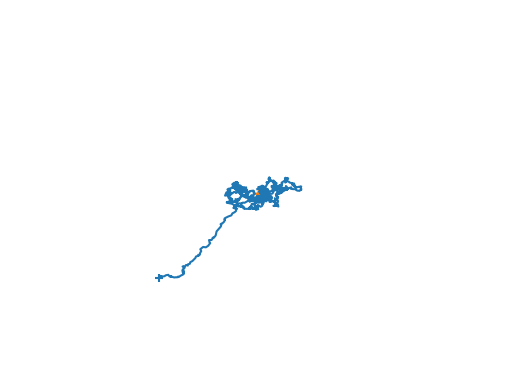

In [ ]:
plt.scatter(states[0, 0], states[0, 1], marker='+')
plt.scatter([0], [0], marker='*')
plt.plot(states[:, 0], states[:, 1])
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.axis('off')
plt.show()

In [ ]:
# Check grad is ok
alpha = 1.5
theta = torch.tensor(env.rng.uniform(-1, 1, (ds + da)**2))
W, W1, W2 = get_estimator_weight(ds, da, theta, tau, eta, alpha)
s, a = get_initial_point(gamma, W, env)
a.requires_grad = True
s_a = torch.concat([s, a])
b = torch.cartesian_prod(s_a, s_a).prod(dim=1)
b = torch.flatten(torch.ger(s_a, s_a) + torch.diag((alpha - 1) * s_a**2))
l = b @ theta.double()
l.backward()
a.grad, s @ W1.T + a @ W2.T

/var/folders/rl/kj05s9097s1_4c4_rglql4y80000gn/T/ipykernel_90966/1247307925.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return W.double(), torch.tensor(W_1).double(), torch.tensor(W_2).double()


(tensor([0.8083, 0.3001], dtype=torch.float64),
 tensor([0.8083, 0.3001], dtype=torch.float64, grad_fn=<AddBackward0>))